In [76]:
library(ncdf4)
library(viridis)
library(fields)
library(rstan)
options(mc.cores = parallel::detectCores())

In [65]:
nc <- nc_open('data/SeaFlow_SizeDist_regrid-15-5.nc')

In [66]:
PAR   <- ncvar_get(nc,'PAR')
w_obs <- ncvar_get(nc,'w_obs')
m     <- ncvar_get(nc,'m')
delta_v_inv <- ncvar_get(nc,'delta_v_inv')
v_min       <- ncvar_get(nc,'v_min')
time  <- ncvar_get(nc,'time')

In [67]:
delta_v <- 1/delta_v_inv
v       <- v_min*2^(0:14*delta_v) 

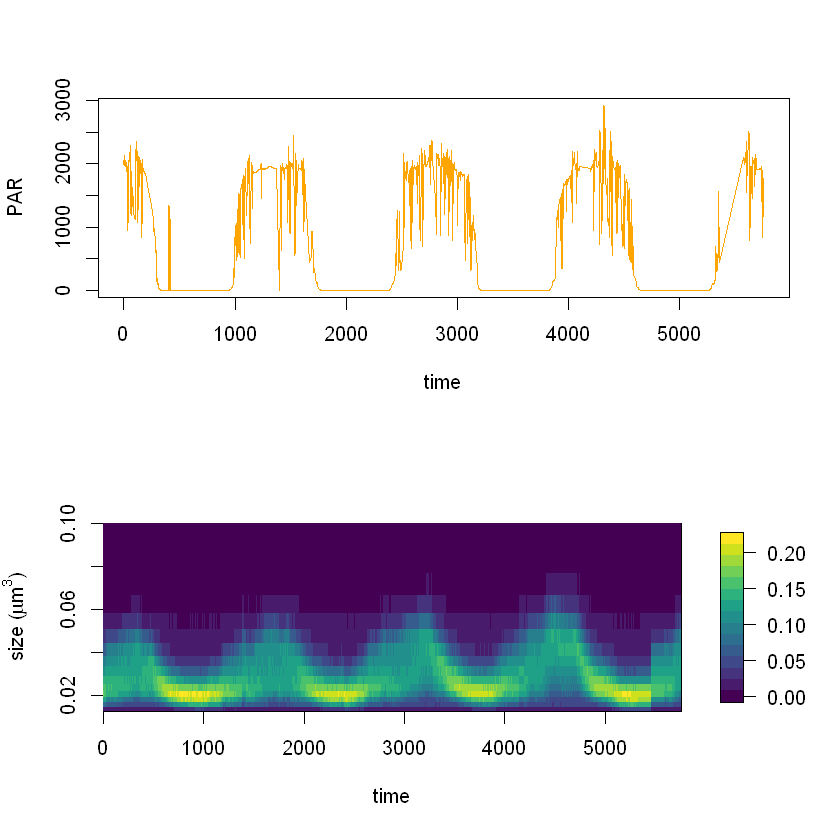

In [68]:
par(mfrow=c(2,1))
plot(time,PAR,type='l',col='orange')
image.plot(x=time,y=v,w_obs,col=viridis(15),xlab='time',ylab=expression('size ('*mu*'m'^3*')'))

In [69]:
stan_code = "data {
    // size variables
    int<lower=0> m;         // number of size classes
    int<lower=0> nt;        // number of timesteps
    int<lower=0> nt_obs;    // number of timesteps with observations
    // model parameters and input
    int<lower=0> dt;        // delta t in minutes
    real<lower=0> E[nt];    // vector of incident radiation values
    real<lower=0> v_min;    // size in smallest size class in um^-3
    int<lower=0> delta_v_inv;   // inverse of delta_v 
    simplex[m] w_ini;       // initial conditions 
    // observations
    real<lower=0,upper=nt*dt>  t_obs[nt_obs]; // the time of each observation
    real<lower=0> obs[m,nt_obs]; // observations
}
transformed data {
    int j;
    real<lower=0> delta_v;
    real<lower=0> dt_days;  // dt in units of days
    real<lower=0> v[m];     // vector of (minimum) sizes for each size class
    int<lower=0> t[nt];     // vector of times in minutes since start 
    int<lower=1, upper=nt> it_obs[nt_obs]; // the time index of each observation

    j = 1 + delta_v_inv; 
    delta_v = 1.0/delta_v_inv;
    dt_days = dt/1440.0;
    for (i in 1:m){
        v[i] = v_min*2^((i-1)*delta_v);
    }
    // populate time vector
    t[1] = 0;
    for (i in 2:nt){
        t[i] = (t[i-1] + dt);
    }
    // populate index vector it_obs
    for (k in 1:nt_obs){
        for (i in 1:nt){
            if (t_obs[k]>=t[i] && t_obs[k]<t[i]+dt){
                it_obs[k] = i;
                break;
            }
        }
    }
}
parameters {
    real<lower=0> b; 
    real<lower=0> delta_max; 
    real<lower=0> gamma_max;
    real<lower=0, upper=5000> E_star; 
    real<lower=1e-10> sigma; 
}
transformed parameters {
    matrix[m,nt_obs] mod_obspos;
    {
        // helper variables
        vector[m] w_curr; 
        vector[m] w_next;
        real delta_i;
        real gamma;
        real a;
        real tmp;
        int ito = 1;
        
        w_curr = w_ini;

        for (it in 1:nt){ // time-stepping loop
            // record current solution 
            if (it == it_obs[ito]){
                mod_obspos[,ito] = w_curr;
                ito += 1;
                if (ito > nt_obs){
                    break;
                }
            }
            // compute gamma
            gamma = gamma_max * dt_days * (1.0 - exp(-E[it]/E_star));

            w_next = rep_vector(0.0, m);
            for (i in 1:m){ // size-class loop
                // compute delta_i
                tmp = v[i]^b; 
                delta_i = delta_max * dt_days * (tmp/(1+tmp));
                
                // fill subdiagonal (growth)
                if (i < j){
                    //A[i+1,i] = gamma;
                    a = gamma;
                    w_next[i+1] += a * w_curr[i];
                } else if (i < m){
                    //A[i+1,i] = gamma * (1.0-delta_i);
                    a = gamma * (1.0-delta_i);
                    w_next[i+1] += a * w_curr[i];
                }
                // fill (j-1)th superdiagonal (division)
                if (i >= j){
                    //A[i+1-j,i] = 2.0*delta_i;
                    a = 2.0*delta_i;
                    w_next[i+1-j] += a * w_curr[i];
                }
                // fill diagonal (stasis)
                if (i < j){
                    //A[i,i] = (1.0-gamma);
                    a = (1.0-gamma);
                    w_next[i] += a * w_curr[i];
                } else if (i == m){
                    //A[i,i] = (1.0-delta_i);
                    a = (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                } else {
                    //A[i,i] = (1.0-gamma) * (1.0-delta_i);
                    a = (1.0-gamma) * (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                }
            }
            w_curr = w_next ./ sum(w_next);
        }
    }
}
model {
    real diff;
    
    // priors
    b ~ normal(1.0,0.8);
    delta_max ~ uniform(0.0,1440.0/dt);
    gamma_max ~ uniform(0.0,1440.0/dt);
    E_star ~ normal(3000.0,1000.0);
    sigma ~ exponential(1000.0);

    // fitting observations
    for (it in 1:nt_obs){
        diff = 0.0;
        for (iv in 1:m){
            diff += fabs(mod_obspos[iv,it] - obs[iv,it]);
        }
        diff = diff/sigma;
        diff ~ normal(0.0, 1.0) T[0,];
    }
}"

In [72]:
data             <- list()
data$w_obs       <- ncvar_get(nc,'w_obs')
data$PAR         <- ncvar_get(nc,'PAR')
data$m           <- ncvar_get(nc,'m')
data$delta_v_inv <- ncvar_get(nc,'delta_v_inv')
data$v_min       <- ncvar_get(nc,'v_min')
data$time        <- ncvar_get(nc,'time')

data$dt      <- 20
data$nt     <- 2*1440/data$dt
data$nt_obs <- length(data$time)

t          <- (0:data$nt)*data$dt
data$E     <- approx(data$time,data$PAR,xout=t)$y
data$return_prior <- 0
data$obs   <- t(data$w_obs)
data$t_obs <- data$time
data$w_ini <- data$w_obs[1,]

limit_to_numdays <- 2.0
stride_t_obs     <- 20

ind_obs    <- data$t_obs > 3
data$t_obs <- data$t_obs[ind_obs]
data$obs   <- data$obs[,ind_obs]

if(limit_to_numdays > 0){
    thresh     <- limit_to_numdays*1440
    ind_obs    <- data$t_obs < thresh
    data$t_obs <- data$t_obs[ind_obs]
    data$obs   <- data$obs[,ind_obs]

    data$nt    <- thresh/data$dt
    data$E     <- data$E[t < thresh]
}

if(stride_t_obs > 0){
    data$t_obs <- data$t_obs[seq(1,length(data$t_obs),stride_t_obs)]
    data$obs   <- data$obs[,seq(1,ncol(data$obs),stride_t_obs)]
}

data$nt_obs <- dim(data$obs)[2]

In [77]:
mod <- stan_model(model_code=stan_code)

In [79]:
mcmc <- sampling(mod,data=data,open_progress=TRUE,control=list(adapt_delta=0.95))

Warning message:
"There were 3301 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Warning message:
"Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess"Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess"

In [80]:
mcmc

Inference for Stan model: 7816575eeb9e5a3429eba2848fd3ec59.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd    2.5%     25%     50%     75%
b                    1.17    0.00   0.05    1.08    1.14    1.17    1.19
delta_max           66.58    0.29   5.02   53.41   64.06   68.09   70.46
gamma_max           22.28    0.35   5.67   11.88   18.05   22.20   25.99
E_star            2980.11   52.16 901.31 1153.34 2389.05 3004.20 3647.45
sigma                0.14    0.00   0.01    0.12    0.13    0.14    0.14
mod_obspos[1,1]      0.02    0.00   0.00    0.02    0.02    0.02    0.02
mod_obspos[1,2]      0.02    0.00   0.00    0.02    0.02    0.02    0.02
mod_obspos[1,3]      0.02    0.00   0.00    0.02    0.02    0.02    0.02
mod_obspos[1,4]      0.03    0.00   0.00    0.02    0.02    0.03    0.03
mod_obspos[1,5]      0.03    0.00   0.00    0.02    0.03    0.03    0.03
mod_obspos[1,6]    

In [81]:
post <- extract(mcmc)

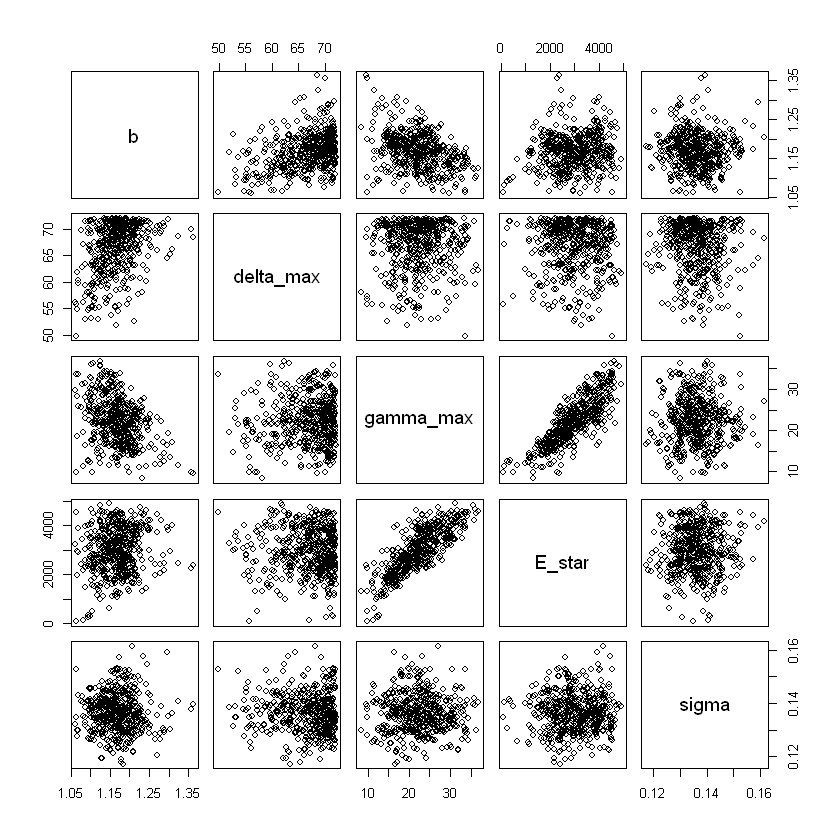

In [87]:
pairs(data.frame(b=post$b,
                 delta_max=post$delta_max,
                 gamma_max=post$gamma_max,
                 E_star=post$E_star,
                 sigma=post$sigma)[sample(1:length(post$b),500),])

In [166]:
res  <- apply(post$mod_obspos,c(2,3),mean)
diff <- res - data$obs

t <- seq(0,2860,length.out=144)
slice_indices <- c(1,3,16)

v_ext <- data$v_min*2^(0:14*delta_v)
v_width <- v_ext[2:15] - v_ext[1:14]

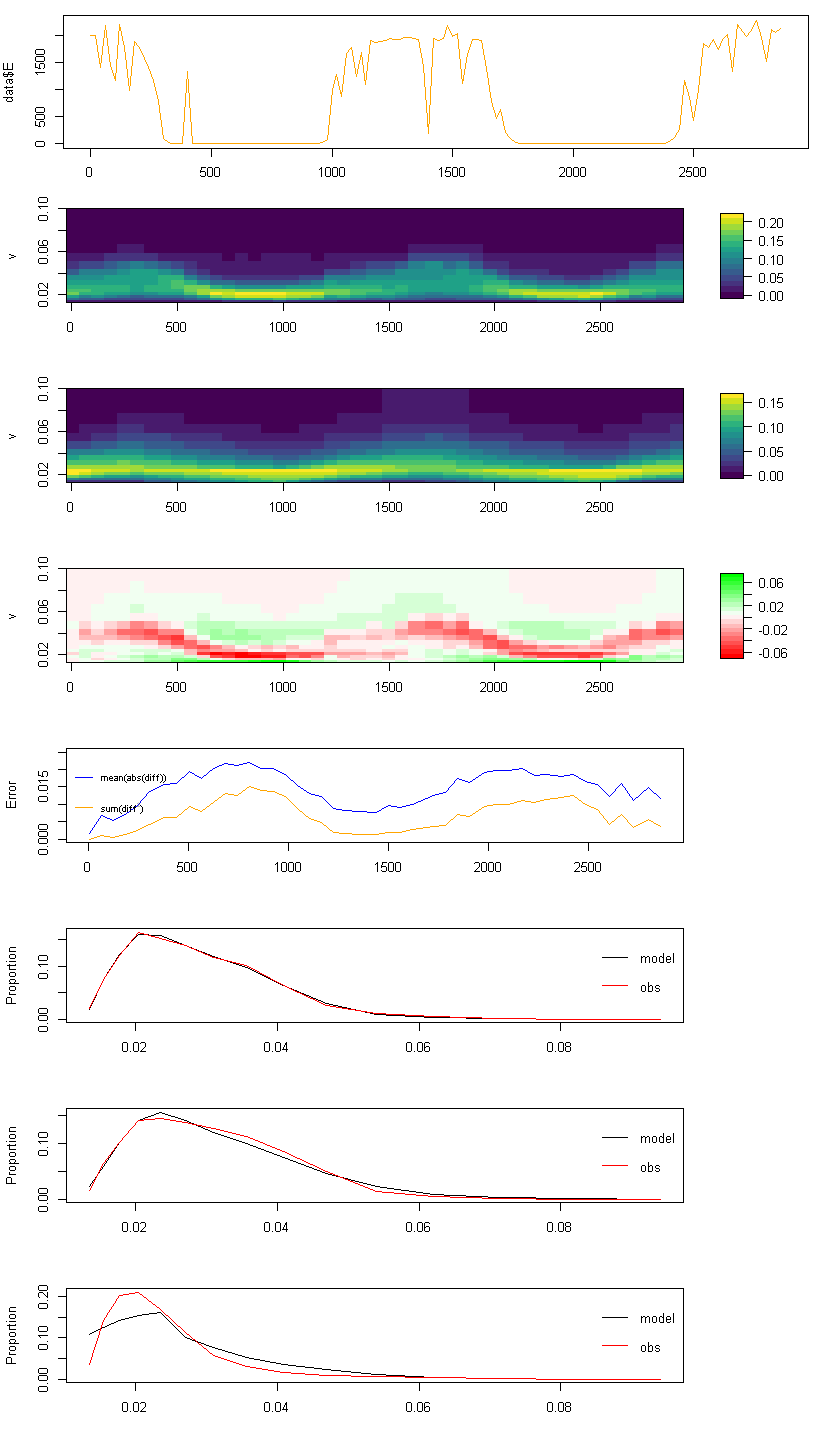

In [171]:
options(repr.plot.width=7, repr.plot.height=12)
par(mfrow=c(8,1),mar=c(2,4,1,2))
plot(t,data$E,col='orange',type='l')
image.plot(x=data$t_obs,y=v,t(data$obs),col=viridis(15),xlab=''); box()
image.plot(x=data$t_obs,y=v,t(res),col=viridis(15),xlab=''); box()
image.plot(x=data$t_obs,y=v,t(diff),col=colorRampPalette(c("red", "white", "green"))(20),xlab=''); box()

plot(data$t_obs,colMeans(abs(diff)),type='l',ylim=c(0,0.025),xlab='',col='blue',ylab='Error')
lines(data$t_obs,colSums(diff^2),col='orange')
legend('topleft',legend=c('mean(abs(diff))',expression('sum(diff'^2*')')),cex=0.7,bty='n',lty=1,col=c('blue','orange'))

for(i in 1:length(slice_indices)){
    plot(v_ext,res[,slice_indices[i]],type='l',ylim=c(0,max(c(data$obs[,slice_indices[i]],res[,slice_indices[i]]))),xlab='',ylab='Proportion')
        lines(v_ext,data$obs[,slice_indices[i]],col='red')
        legend('topright',legend=c('model','obs'),bty='n',lty=1,col=c('black','red'))
}